In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib notebook


Take a system of $N$, with each agent $i=1\ldots N$ has a binary choice $S_i=\pm1$, with the positive choice indicating for example that he wants to buy an asset. We suppose now that the agent wants to maximize an "utility function" given by:

$$
U_i = h_i S_i + F S_i + S_i\sum_{j(\neq i)}J_{ij}S_j
$$
where $h_i$ is an idiosyncratic bias proper to each agent. We suppose that the $h_i$ are random iid. variables with a density $\rho(h)$. The agent's decision is then naturally given by:

\begin{equation}\label{eq:decision}
    S_i = \mbox{sign}\left(h_i + F  + \sum_{j(\neq i)}J_{ij}S_j\right):=\mbox{sign}(p_i)
\end{equation}
where $p_i$ is the "local polarization field".

In [2]:
class RFIM(object):
    '''A class for simulating the Random Field Ising Model '''
    
    def __init__(self, J, F, N, delta):
        '''Create an instance of the RFIM with parameters J,F
        of size N, with fields h with a random Laplace distribution of parameter delta'''
        self.J = J
        self.F = F
        self.N = N
        self.S= np.random.choice([-1,1], size = N)
        self.h = np.random.laplace(scale = delta, size = N)
        
        
    def m(self):
        '''Computes average opinion '''
        return np.mean(self.S)
                                   
    
    
    def p(self, i):
        '''Computes the local opinion polarization for agent i p_i
        inputs: agent label i
        returns: the field p_i'''
        local_m = (self.S.sum() - self.S[i]) / (self.N - 1)
        return self.h[i] + self.F + self.J * local_m
    
    def flip(self,i):
        '''Changes S_i -> -S_i according to the dynamic rule
        input: agent label i
        returns: 0 if the agent didn't change opinion
                 1 if the agent changed opinion
        '''
        should_flip = self.S[i] * np.sign(self.p(i))
        if should_flip == -1:
            self.S[i] *= -1
            return 1
        else:
            return 0
    
    
    def sweep(self):
        '''Goes through all N agents and tries to flip them
        input: none
        returns: number of agents that changed their mind
        '''
        s = 0
        for i in range(N):
            s += self.flip(i)
        return s
    
    def equilibrate(self):
        '''Find the equilibrium of the system'''
        flips = self.sweep()
        while flips > 0:
            flips = self.sweep()
            


<IPython.core.display.Javascript object>


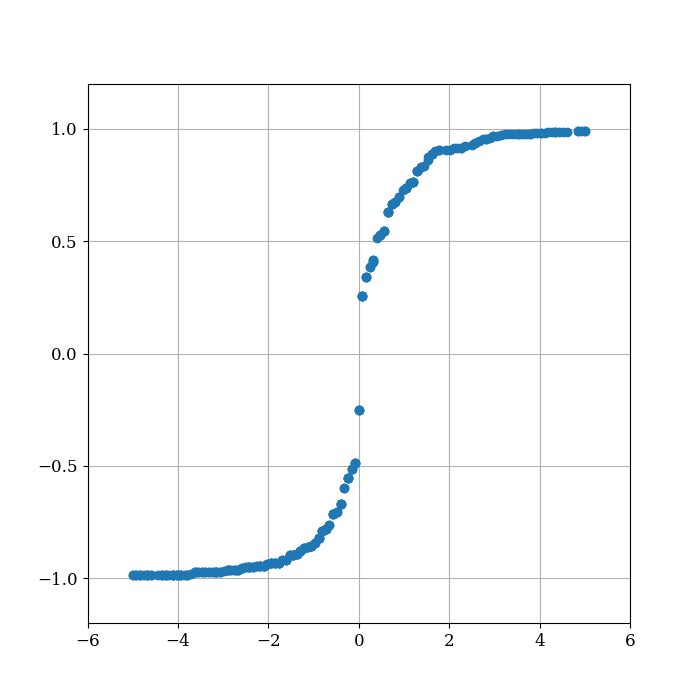

interactive(children=(FloatSlider(value=5.0, description='F', max=5.0, min=-5.0, step=0.01), Output()), _dom_c…

<function __main__.set_F_and_eq(F=10)>

In [11]:
fig, ax = plt.subplots()
ax.set_xlim(-6,6)
ax.set_ylim(-1.2, 1.2)
ax.grid()
F = 10
delta = 1.2
N = 500
J = 1
sim = RFIM(J,F,N, delta)
Fs = []
ms = []
sim.equilibrate()
Fs.append(F)
ms.append(sim.m())
scat, = ax.plot(Fs, ms, 'o')


def set_F_and_eq(F=10):
    sim.F = F
    sim.equilibrate()
    Fs.append(F)
    ms.append(sim.m())
    scat.set_data(Fs, ms)
    fig.canvas.draw_idle()
    
interact(set_F_and_eq, F=(-5,5,0.01))

<IPython.core.display.Javascript object>


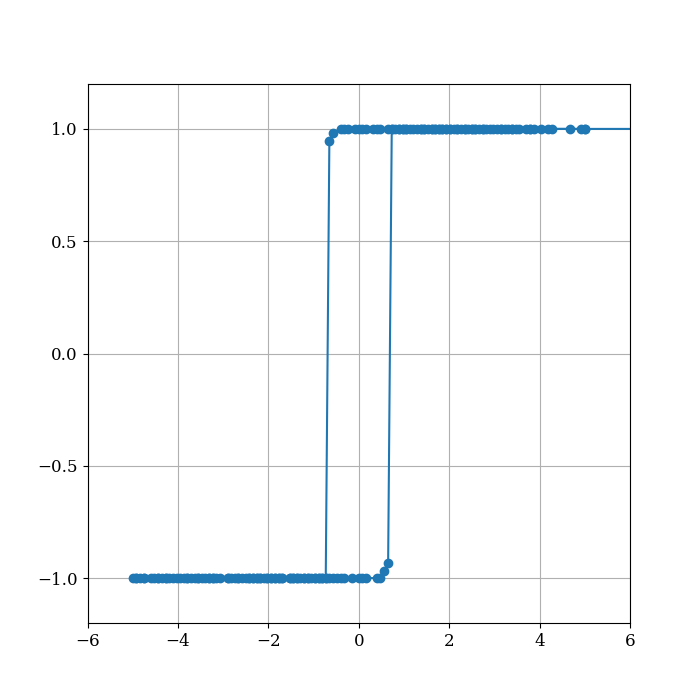

interactive(children=(FloatSlider(value=5.0, description='F', max=5.0, min=-5.0, step=0.01), Output()), _dom_c…

<function __main__.set_F_and_eq(F=5)>

In [14]:
fig, ax = plt.subplots()
ax.set_xlim(-6,6)
ax.set_ylim(-1.2, 1.2)
ax.grid()
F = 10
delta = 0.1
N = 300
J = 1
sim = RFIM(J,F,N, delta)
Fs = []
ms = []
sim.equilibrate()
Fs.append(F)
ms.append(sim.m())
scat, = ax.plot(Fs, ms, 'o-')


def set_F_and_eq(F=5):
    sim.F = F
    sim.equilibrate()
    Fs.append(F)
    ms.append(sim.m())
    scat.set_data(Fs, ms)
    fig.canvas.draw_idle()
    
interact(set_F_and_eq, F=(-5,5,0.01))